In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt




In [17]:
df = pd.read_csv("data/traffic_weather_merged.csv")
df.head()



,instance_id,segment_id,date,interval,uptime,heavy,car,bike,pedestrian,night,...,car_speed_hist_0to120plus,timezone,v85,temperature_c,precipitation_mm,rain_mm,snowfall_cm,cloud_cover_pct,wind_speed_kmh,sunshine_duration_s
0,-1,9000008372,2025-11-21 09:00:00+01:00,hourly,0.499722,0.0,34.0,4.0,4.0,0.0,...,"[52.9411764706, 5.8823529412, 5.8823529412, 11...",Europe/Paris,27.5,0.2,0.0,0.0,0.0,100,12.2,6.59
1,-1,9000008372,2025-11-21 10:00:00+01:00,hourly,0.999444,0.0,39.0,11.0,6.0,0.0,...,"[48.7179487179, 12.8205128205, 12.8205128205, ...",Europe/Paris,25.5,0.8,0.0,0.0,0.0,100,13.4,3600.00
2,-1,9000008372,2025-11-21 11:00:00+01:00,hourly,0.999167,2.0,31.0,16.0,6.0,0.0,...,"[45.1612903226, 3.2258064516, 6.4516129032, 12...",Europe/Paris,29.5,1.3,0.0,0.0,0.0,100,11.0,672.91
3,-1,9000008372,2025-11-21 12:00:00+01:00,hourly,0.999722,1.0,47.0,30.0,20.0,0.0,...,"[42.5531914894, 6.3829787234, 12.7659574468, 8...",Europe/Paris,32.5,2.4,0.0,0.0,0.0,98,9.6,3600.00
4,-1,9000008372,2025-11-21 13:00:00+01:00,hourly,0.999167,1.0,26.0,19.0,36.0,0.0,...,"[50.0, 3.8461538462, 3.8461538462, 7.692307692...",Europe/Paris,35.5,2.6,0.0,0.0,0.0,100,9.2,3600.00


In [18]:
# convert ISO timestamp string to real datetime
df["datetime"] = pd.to_datetime(df["date"])  # your date column already has timestamp
df["date_only"] = df["datetime"].dt.date
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek  # 0=Mon
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

df[["datetime", "hour", "dayofweek", "is_weekend"]].head()

,datetime,hour,dayofweek,is_weekend
0,2025-11-21 09:00:00+01:00,9,4,0
1,2025-11-21 10:00:00+01:00,10,4,0
2,2025-11-21 11:00:00+01:00,11,4,0
3,2025-11-21 12:00:00+01:00,12,4,0
4,2025-11-21 13:00:00+01:00,13,4,0


In [19]:
holidays = pd.read_csv("data/belgian_holidays.csv")
holidays["date"] = pd.to_datetime(holidays["date"]).dt.date
holidays["is_holiday"] = 1

vac = pd.read_csv("data/school_vacations.csv")
vac["date"] = pd.to_datetime(vac["date"]).dt.date
vac["is_school_vacation"] = 1

df = df.merge(holidays[["date", "is_holiday"]],
              left_on="date_only", right_on="date", how="left")
df = df.merge(vac[["date", "is_school_vacation"]],
              left_on="date_only", right_on="date", how="left")

df["is_holiday"] = df["is_holiday"].fillna(0).astype(int)
df["is_school_vacation"] = df["is_school_vacation"].fillna(0).astype(int)

df[["datetime","is_holiday","is_school_vacation"]].head()


,datetime,is_holiday,is_school_vacation
0,2025-11-21 09:00:00+01:00,0,0
1,2025-11-21 10:00:00+01:00,0,0
2,2025-11-21 11:00:00+01:00,0,0
3,2025-11-21 12:00:00+01:00,0,0
4,2025-11-21 13:00:00+01:00,0,0


In [20]:
# target: total people per hour
df["total_people"] = df["car"] + df["bike"] + df["pedestrian"]

feature_cols = [
    "hour",
    "dayofweek",
    "is_weekend",
    "is_holiday",
    "is_school_vacation",
    "temperature_c",
    "precipitation_mm",
    "cloud_cover_pct",
    "wind_speed_kmh",
]

df_model = df.dropna(subset=feature_cols + ["total_people"])
X = df_model[feature_cols]
y = df_model["total_people"]

X.head(), y.head()


(   hour  dayofweek  is_weekend  is_holiday  is_school_vacation  temperature_c  \
 0     9          4           0           0                   0            0.2   
 1    10          4           0           0                   0            0.8   
 2    11          4           0           0                   0            1.3   
 3    12          4           0           0                   0            2.4   
 4    13          4           0           0                   0            2.6   
 
    precipitation_mm  cloud_cover_pct  wind_speed_kmh  
 0               0.0              100            12.2  
 1               0.0              100            13.4  
 2               0.0              100            11.0  
 3               0.0               98             9.6  
 4               0.0              100             9.2  ,
 0    42.0
 1    56.0
 2    53.0
 3    97.0
 4    81.0
 Name: total_people, dtype: float64)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [22]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
y_pred = rf.predict(X_test)


In [25]:


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)   # no squared argument
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 4.016063792177428
RMSE: 9.967237211322045


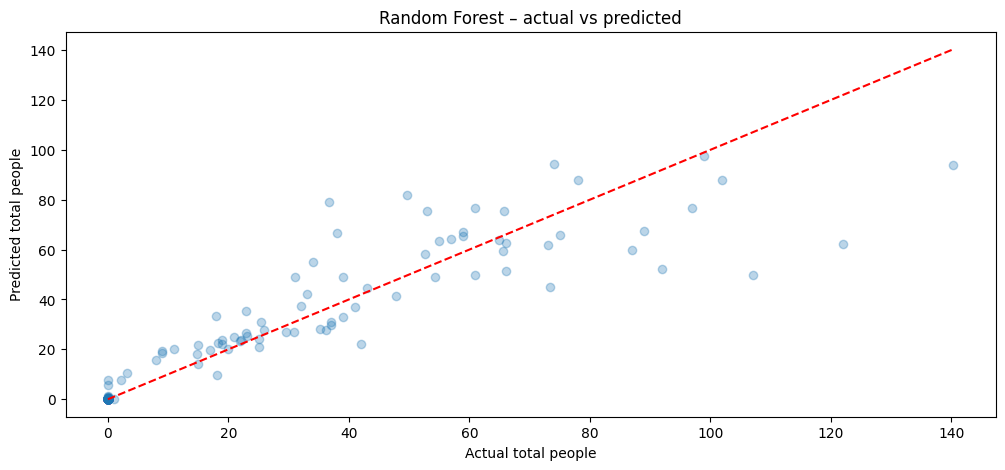

In [40]:
plt.figure(figsize=(12,5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual total people")
plt.ylabel("Predicted total people")
plt.title("Random Forest – actual vs predicted")
plt.show()


In [28]:
import numpy as np

importances = rf.feature_importances_
for name, val in sorted(zip(X.columns, importances),
                        key=lambda x: x[1], reverse=True):
    print(f"{name}: {val:.3f}")


hour: 0.663
is_school_vacation: 0.090
dayofweek: 0.080
wind_speed_kmh: 0.062
temperature_c: 0.061
is_weekend: 0.020
cloud_cover_pct: 0.015
precipitation_mm: 0.007
is_holiday: 0.001


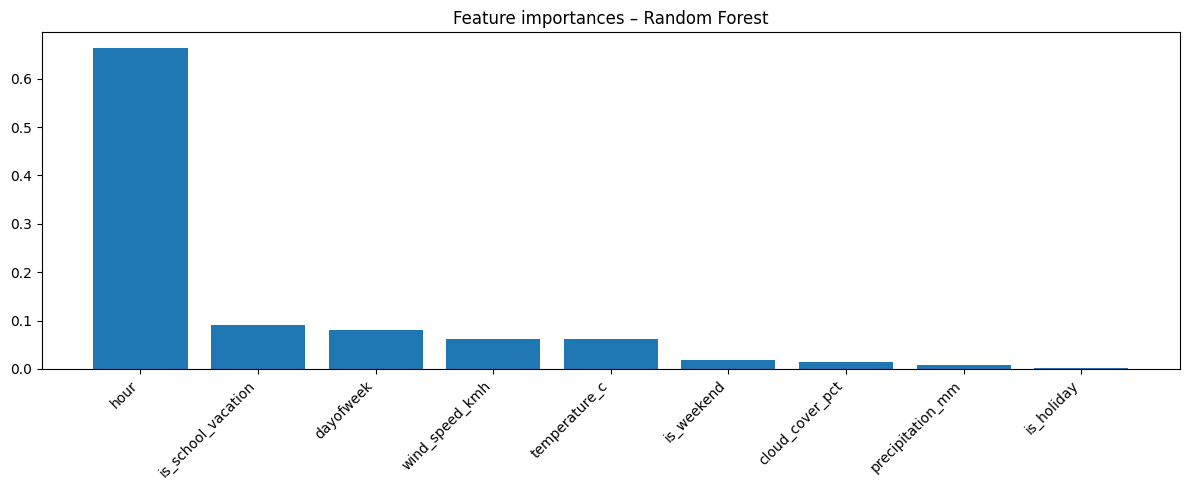

In [39]:
plt.figure(figsize=(12,5))
idx = np.argsort(importances)[::-1]
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), X.columns[idx], rotation=45, ha="right")
plt.title("Feature importances – Random Forest")
plt.tight_layout()
plt.show()


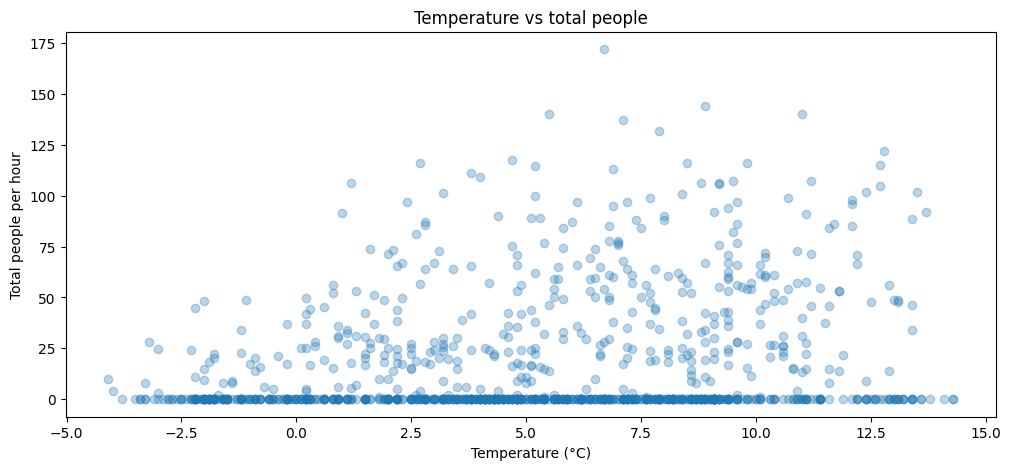

In [38]:
plt.figure(figsize=(12,5))
plt.scatter(df_model["temperature_c"], df_model["total_people"], alpha=0.3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Total people per hour")
plt.title("Temperature vs total people")
plt.show()


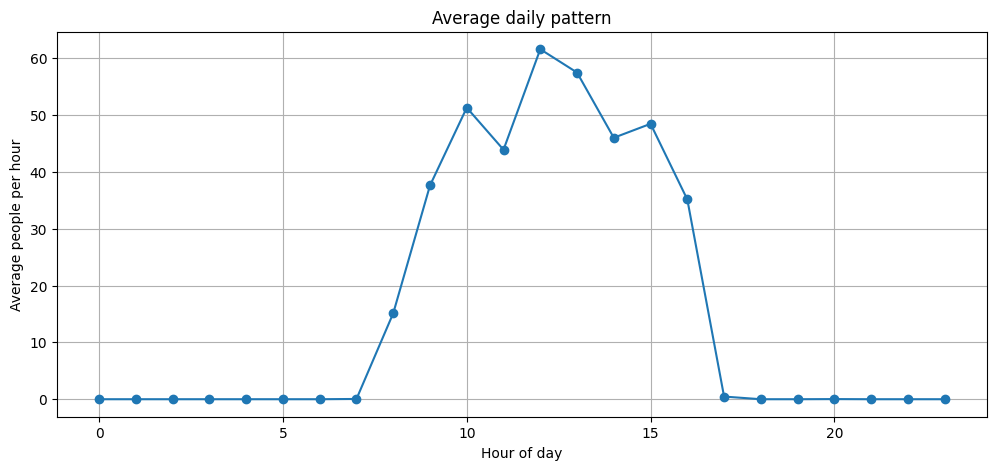

In [37]:
avg_by_hour = df_model.groupby("hour")["total_people"].mean()

plt.figure(figsize=(12,5))
plt.plot(avg_by_hour.index, avg_by_hour.values, marker="o")
plt.xlabel("Hour of day")
plt.ylabel("Average people per hour")
plt.title("Average daily pattern")
plt.grid(True)
plt.show()


In [32]:
avg_by_group = df_model.groupby(
    ["is_holiday", "is_school_vacation"]
)["total_people"].mean().reset_index()

print(avg_by_group)


   is_holiday  is_school_vacation  total_people
0           0                   0     20.149187
1           0                   1      9.789123
2           1                   1      4.595236


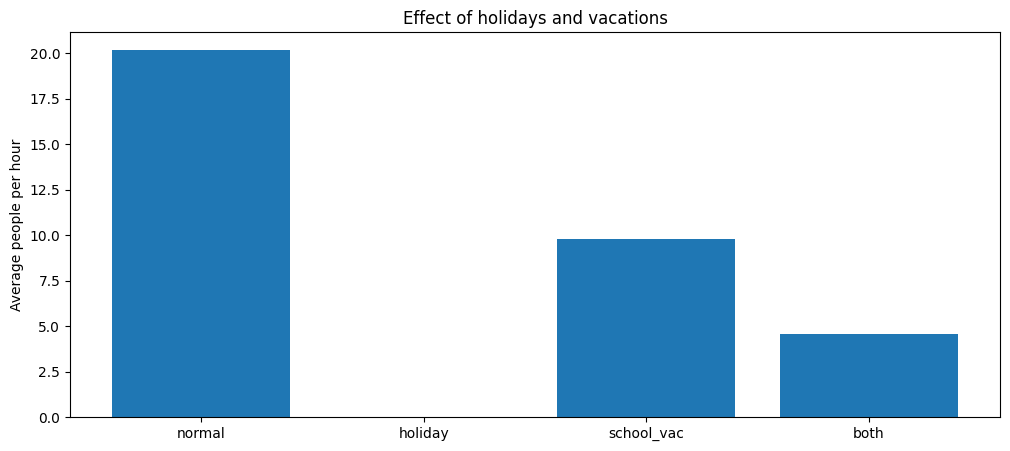

In [36]:
labels = ["normal", "holiday", "school_vac", "both"]
avg_vals = []

for h, v in [(0,0), (1,0), (0,1), (1,1)]:
    avg_vals.append(
        df_model[
            (df_model["is_holiday"]==h) &
            (df_model["is_school_vacation"]==v)
        ]["total_people"].mean()
    )

plt.figure(figsize=(12,5))
plt.bar(labels, avg_vals)
plt.ylabel("Average people per hour")
plt.title("Effect of holidays and vacations")
plt.show()


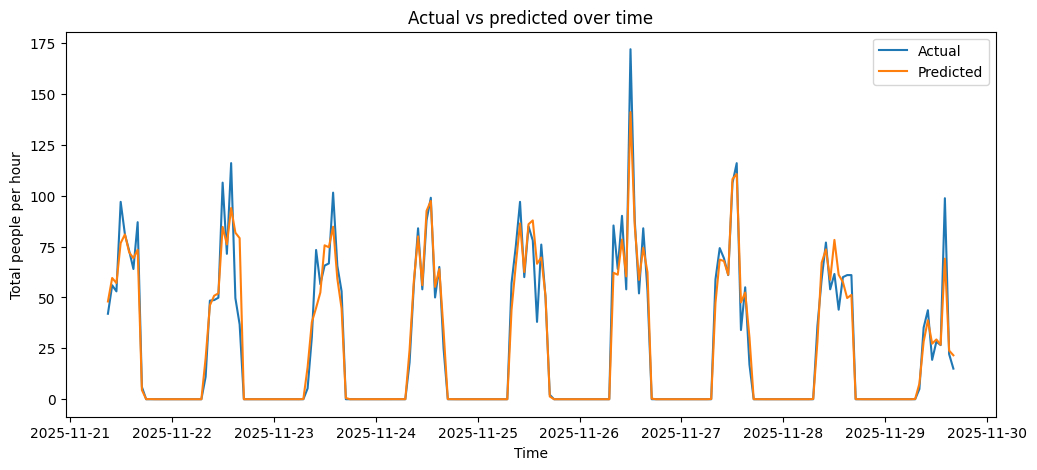

In [42]:
sample = df_model.iloc[:200].copy()
sample_X = sample[feature_cols]
sample["pred_total"] = rf.predict(sample_X)

plt.figure(figsize=(12,5))
plt.plot(sample["datetime"], sample["total_people"], label="Actual")
plt.plot(sample["datetime"], sample["pred_total"], label="Predicted")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Total people per hour")
plt.title("Actual vs predicted over time")
plt.show()


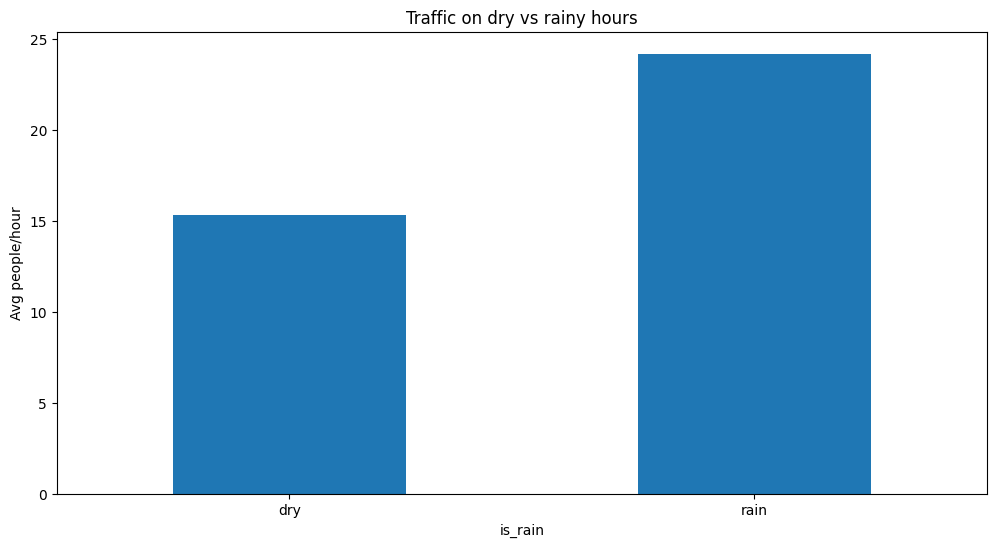

In [47]:
df_model["is_rain"] = (df_model["precipitation_mm"] > 0).astype(int)
avg_rain = df_model.groupby("is_rain")["total_people"].mean()
avg_rain.plot(kind="bar", rot=0 , figsize=(12,6))

plt.xticks([0,1], ["dry", "rain"])
plt.ylabel("Avg people/hour")
plt.title("Traffic on dry vs rainy hours")
plt.show()
